# Sruly Rosenblat Final Project

## Chess by Proximity:  Playing Chess using Embeddings and N-grams

For N-gram testing
- download dependence's
- prepare classes
- prepare functions
- load data if already cleaned
- split train test
- train and test N-gram model


For Embeddings model testing
- download dependence's
- prepare classes
- prepare functions
- load data if already cleaned
- split train test
- test model


# download dependence's  

In [238]:
%pip install --upgrade pip
# for cpu
%pip install faiss-cpu
# for gpu
# %pip install faiss-gpu
%pip install seaborn
%pip install  redis

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement redis-server (from versions: none)
ERROR: No matching distribution found for redis-server
Note: you may need to restart the kernel to use updated packages.


In [4]:
import chess.pgn
import numpy as np
from gensim.models import Word2Vec
import json
from sklearn.model_selection import train_test_split
import asyncio
import io
import faiss
import random
from nltk.util import ngrams
import pandas as pd
import redis
import seaborn as sns
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)


## Redis or dictionary setup

I used redis to speed up the testing process by caching valid moves

In [5]:

# redis is faster but requires a server to be running
# red = redis.Redis(host='localhost', port=6379, db=0, charset="utf-8", decode_responses=True)

# I made it that a dictionary can be used as a drop in replacement of redis, no api keys required 😀
red = {}

# prepare classes to aid in testing

In [23]:


class MoveSet():
    '''
    a class that stores a set of moves
    '''
    def __init__(self) -> None:
        self.moves = set()
    def add(self, move : str):
        self.moves.add(move)
    def __str__(self) -> str:
        return str(self.moves)
    def __repr__(self) -> str:
        return str(self)
    def __len__(self) -> int:
        return len(self.moves)
    
class CounterByMove():
    '''
    a class that tracks valid moves by move count
    '''
    def __init__(self):
        self.moves = []
        self.largestMove = 0


    def addMoves(self, k, validMoves : list | set):
        '''
        adds a set of moves to the tracker
        '''
        if k == self.largestMove:
            self.largestMove = self.largestMove + 1
            self.moves.append(MoveSet())
        elif k > self.largestMove:
            raise IndexError("k must be less than or equal to the largest move")  
        for move in validMoves:
            self.moves[k].add(move)
    def moveCount(self):
        '''
        returns the number of moves that have been added
        '''
        return sum([len(moveSet) for moveSet in self.moves])
    def __getitem__(self, key):
        if key < 0:
            raise IndexError("key must be positive")
        if key > self.largestMove:
            return MoveSet()
        return self.moves[key]
    def validAverage(self):
        '''
        returns the average number of valid moves per move
        '''
        count = self.moveCount()
        if  count == 0:
            return 0
        return [len(moveSet) / count for moveSet in self.moves] 
    def __str__(self):
        return str(self.moves)
    def __repr__(self) -> str:
        return str(self)
        
    
class ProbabilityTracker():
    '''
    a class that tracks the probability of a move being played
    '''
    def __init__(self):
        self.value = 0
        self.count = 0
        self.zeroCount = 0

    def add(self, value : float | int):
        self.value += value
        self.count += 1 
        if value == 0:
            self.zeroCount += 1
        return self
    
    def __iadd__(self, value : float | int):
        return self.add(value)
    

    
    def average(self):
        if self.count == 0:
            return 0
        return self.value/self.count
    
    def nonZeroAverage(self):
        if self.count == 0:
            return 0
        return self.value/(self.count - self.zeroCount)
    
    def opposite(self):
        return 1 - self.average()
    
    def __str__(self):
        return str(self.average())
    
    def __repr__(self):
        return f'prob({self.__str__()})'
    

class probabilityByMove():
    '''
    a class that tracks the probability of every move in a game

    if you try to access a move that hasn't been accessed before, it will return a new probabilityTracker
    '''
    def __init__(self):
        self.moveProbabilities = {}
        self.largestMove = 0
    def average(self):
        '''
        returns the average probability of all moves
        '''
        averages = self.averages()
        averages = [move for move in averages if move != None]
        # print(len(averages))
        return sum(averages) / len(averages) 
    def averages(self):
        '''
        returns a list of the average probability of each move
        '''
        li = []
        for move in range(self.largestMove + 1):
            # if move in self.moveProbabilities:
                li.append(self[move].average())
            # else:
            #     print
            #     li.append(None)
        return li
    
    def nonZeroAverages(self):
        '''
        returns a list of the average probability of each move, but only counting the games where the move was played
        '''
        li = []
        for move in range(self.largestMove + 1):
            if move in self.moveProbabilities:
                li.append(self[move].nonZeroAverage())
            else:
                li.append(None)
        return li
    
    
    def __getitem__(self, key):
        if key < 0:
            raise IndexError("key must be positive")
        if key not in self.moveProbabilities:
            tracker = ProbabilityTracker()
            self.moveProbabilities[key] = tracker
            return self.moveProbabilities[key]
        return self.moveProbabilities[key]
    
    def __setitem__(self,key, value):
        if key not in self.moveProbabilities:
            tracker = ProbabilityTracker()
            tracker += value
            self.moveProbabilities[key] = tracker
        else:
            self.moveProbabilities[key] = value
        self.largestMove = max(self.largestMove, key)
        
    def __str__(self):
        return str(self.averages())
    
    def __repr__(self):
        return self.__str__()
    def __iter__(self):
        for move in self.moveProbabilities:
            yield self.moveProbabilities[move]


# prepare Functions
used in both N-gram and embedding models

In [21]:
# validMovesDict = {}

def incrementCount(dic,priorMoves,key):
    if not dic.get(priorMoves):
        dic[priorMoves] = {}
    if key in dic[priorMoves]:
        dic[priorMoves][key] += 1
    else:
        dic[priorMoves][key] = 1
    return dic

def calculateProbability(dic:dict):
    probabilities = {}
    total = sum(dic.values())
    for key in dic:
        probabilities[key] = dic[key]/total
    return probabilities

def randomMove(moves:dict):
    probabilities = calculateProbability(moves)
    weights = list(probabilities.values())
    moves = list(probabilities.keys())
    return random.choices(moves, weights=weights, k=1)[0]

def getValidMoves(pgn: str):
    try:
        if red.get(pgn) != None:
            return json.loads(red.get(pgn)) 
    except:
        pass

    game = chess.pgn.read_game(io.StringIO(pgn))
    if game and  game.errors:
        raise Exception("Invalid PGN" + game.errors)
    if pgn:
            
            mainline_moves = game.mainline_moves()
    else:
        mainline_moves = []
    
    
    board = chess.Board()
    for move in mainline_moves:
        board.push(move)
    legalMoves = [board.san(x) for x in board.legal_moves]
    if type(red) == dict:
        red[pgn] = json.dumps(legalMoves)
    else:
        red.set(pgn,json.dumps(legalMoves))

    return legalMoves

    
def probabilityMoveValid(pgn:str, moves:dict):
    probabilities = calculateProbability(moves)
    validMoves = getValidMoves(pgn)
    probability = 0
    for move in validMoves:
        if move in probabilities:
            probability += probabilities[move]
    return probability, validMoves

def probabilityMoveSame(moves:dict, expectedMove:str):
    probabilities = calculateProbability(moves)
    if expectedMove in probabilities:
        return probabilities[expectedMove]
    else:
        return 0


# prepare data
clean data then save it 


In [40]:
def fixMoves(pgn: str):
    '''
    make moves the same format as chess library takes
    '''
    game = chess.pgn.read_game(io.StringIO(pgn))
    if  game.errors:
        raise Exception("Invalid PGN" + game.errors)
    board = chess.Board()
    if pgn:
            mainline_moves = game.mainline_moves()
    else:
        mainline_moves = []
    board = chess.Board()
    pgn = ''

    for move in mainline_moves:
        pgn += board.san(move) + ' '
        board.push(move)
    return pgn.strip()

In [41]:
gamesDF = pd.read_csv('games.csv')
set(gamesDF['victory_status'] )


{'draw', 'mate', 'outoftime', 'resign'}

In [42]:
with open('games.txt','w') as f:
    for gram in gamesDF.iterrows():
        
        f.write(gram[1]['moves'] + '\n')

In [43]:
with open('games.txt', 'r') as f:
    tempGames = f.read().splitlines()

    with open('cleanedGames.txt', 'w') as f2:
        for gram in tempGames:
            try:
                fixed = fixMoves(gram)
                movesInPGN  = fixed.split(' ')
                if len(movesInPGN) > 5 and len(movesInPGN) < 130:
                    f2.write(fixed + '\n')
                # f2.write(fixed + '\n')
            except Exception as e:
                print(e)

# Load data
read results into games array

In [9]:
# Load the chess game data from file
with open('cleanedGames.txt', 'r') as f:
    games = f.read().splitlines()

# put the games into a list of lists
games = [game.split() for game in games]
len(games)

18891

# Train Test Split

split train test sets

In [10]:
# split the data into training and testing sets
train, test = train_test_split(games, test_size=0.2, random_state=42)
len(train), len(test)

(15112, 3779)

# train and test N-gram model


In [27]:
# prepare the data for the model
N = 5
grams  = []
for gram in train:
    for x in ngrams(gram,N, pad_left=True, left_pad_symbol='<s>' ):
        grams.append(x)
len(grams)

874506

In [28]:
moveDict = {}
for gram in grams:
    incrementCount(moveDict, ' '.join(gram[:-1]), gram[-1])

In [176]:
grams[:25]

[('<s>', '<s>', '<s>', '<s>', 'd4'),
 ('<s>', '<s>', '<s>', 'd4', 'c6'),
 ('<s>', '<s>', 'd4', 'c6', 'e4'),
 ('<s>', 'd4', 'c6', 'e4', 'd5'),
 ('d4', 'c6', 'e4', 'd5', 'exd5'),
 ('c6', 'e4', 'd5', 'exd5', 'cxd5'),
 ('e4', 'd5', 'exd5', 'cxd5', 'Nc3'),
 ('d5', 'exd5', 'cxd5', 'Nc3', 'Nf6'),
 ('exd5', 'cxd5', 'Nc3', 'Nf6', 'Bg5'),
 ('cxd5', 'Nc3', 'Nf6', 'Bg5', 'Bf5'),
 ('Nc3', 'Nf6', 'Bg5', 'Bf5', 'Bxf6'),
 ('Nf6', 'Bg5', 'Bf5', 'Bxf6', 'exf6'),
 ('Bg5', 'Bf5', 'Bxf6', 'exf6', 'Nf3'),
 ('Bf5', 'Bxf6', 'exf6', 'Nf3', 'Bd6'),
 ('Bxf6', 'exf6', 'Nf3', 'Bd6', 'Bb5+'),
 ('exf6', 'Nf3', 'Bd6', 'Bb5+', 'Nc6'),
 ('Nf3', 'Bd6', 'Bb5+', 'Nc6', 'Nxd5'),
 ('Bd6', 'Bb5+', 'Nc6', 'Nxd5', 'Bb4+'),
 ('Bb5+', 'Nc6', 'Nxd5', 'Bb4+', 'Nxb4'),
 ('<s>', '<s>', '<s>', '<s>', 'd4'),
 ('<s>', '<s>', '<s>', 'd4', 'd5'),
 ('<s>', '<s>', 'd4', 'd5', 'Bf4'),
 ('<s>', 'd4', 'd5', 'Bf4', 'Bf5'),
 ('d4', 'd5', 'Bf4', 'Bf5', 'Nc3'),
 ('d5', 'Bf4', 'Bf5', 'Nc3', 'c6')]

In [29]:
# initialize counters for probabilities
probabilityValid = probabilityByMove()
probabilityCorrect = probabilityByMove()
probabilityCorrectIfValid = probabilityByMove()

# used to keep track of valid moves by move number
validCounter = CounterByMove()


# run test
for game in test:
    # keep track of state in game
    movesSoFar = ['<s>'] * 4
    moveIndex = 0
    for moveIndex, move in enumerate(game):
        moves = ' '.join(movesSoFar[-4::])
        search =  moveDict.get(moves, {})
        probValid,validMoves  = probabilityMoveValid(' '.join(movesSoFar), search)
        validCounter.addMoves(moveIndex, validMoves)
        probSame = probabilityMoveSame(search, move)
        probabilityValid[moveIndex] += probValid
        if probValid > 0:
            probabilityCorrectIfValid[moveIndex] += probSame
        probabilityCorrect[moveIndex] += probSame
        movesSoFar.append(move)


In [179]:
len(test)

3779

In [30]:
probabilityValid.average(), probabilityCorrect.average(),probabilityCorrectIfValid.average()

(0.15031562579979116, 0.09231569582309467, 0.787501560672794)

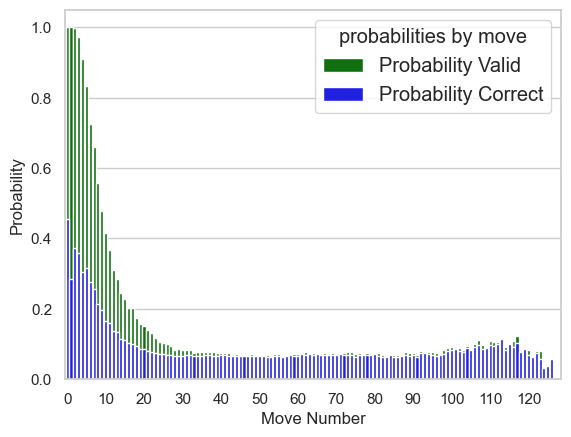

In [182]:
# comparing the probabilities of valid moves and correct moves for each move number 
rangeOfPlot = [x for x in range(len(probabilityCorrect.averages()))]
sns.set_theme(style="whitegrid")

# creating subplots
fig, ax = plt.subplots()

# plotting columns
sns.barplot(x=rangeOfPlot, y=probabilityValid.averages(), color="green", ax=ax, label='Probability Valid')
sns.barplot(x=rangeOfPlot, y=probabilityCorrect.averages(), color="blue", ax=ax, label='Probability Correct',alpha=1)

# renaming the axes
ax.set(xlabel="Move Number", ylabel="Probability")

# setting ticks for x-axis
ax.set_xticks(rangeOfPlot[::10])
ax.set_xticklabels(rangeOfPlot[::10])

# adding legend
ax.legend(title='probabilities by move', title_fontsize='large', fontsize='large')

# visualizing illustration
plt.show()

<AxesSubplot: >

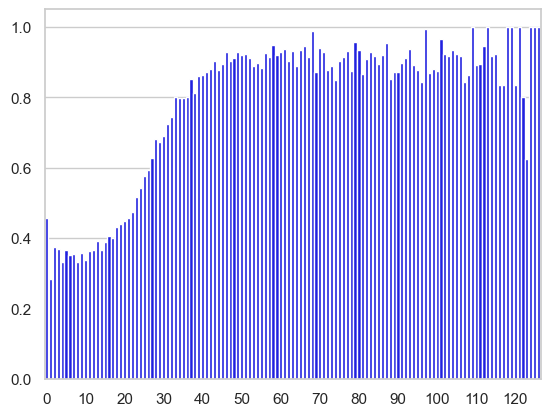

In [183]:
rangeOfPlot = [x for x in range(len(probabilityCorrectIfValid.averages()))]
# sns.histplot(x =probabilityValid.averages(), bins=15)
sns.set_theme(style="whitegrid", )
sns.color_palette("light:#5A9", as_cmap=True)
plot = sns.barplot(x=rangeOfPlot, y=probabilityCorrectIfValid.averages(), color="blue")
ax.legend(title='probabilities by move', title_fontsize='large', fontsize='large')


plt.xticks(rangeOfPlot[::10], rangeOfPlot[::10])
plot

### graphs


# train and test Embedding models


## train word2Vec


In [11]:
# Initialize the Word2Vec model
VectorSize = 32
window = 5

model = Word2Vec(train, window=window, vector_size=VectorSize)

## prepare model

In [14]:
moveSet = set()
moveDict = {}
for game in train:
    movesSoFar = ''
    for moveIndex, move in enumerate(game):
        if moveIndex == len(game)-1:
            continue
        if moveIndex == 0:
            incrementCount(moveDict,movesSoFar,move)
            moveSet.add(movesSoFar)       
            movesSoFar += ' ' +  move 
            movesSoFar = movesSoFar.strip()
            continue
        incrementCount(moveDict,movesSoFar,game[moveIndex])
        moveSet.add(movesSoFar.strip())
        movesSoFar += ' ' +  move
        movesSoFar = movesSoFar.strip()
        
        

In [266]:
# example of moveDict
moveDict['e4 e5']

{'Nf3': 3234,
 'd3': 112,
 'Bc4': 391,
 'Qh5': 151,
 'c4': 27,
 'f4': 177,
 'Nc3': 102,
 'd4': 248,
 'a3': 14,
 'b3': 3,
 'Qf3': 47,
 'Bb5': 18,
 'Ke2': 3,
 'c3': 16,
 'g3': 6,
 'f3': 17,
 'Ne2': 3,
 'Bd3': 7,
 'a4': 1,
 'Qg4': 2,
 'g4': 3,
 'h3': 4,
 'b4': 1,
 'Be2': 1,
 'h4': 1}

In [267]:
# get a random move from the moveDict based on probability
randomMove(moveDict['e4 e5'])

'Nf3'

In [268]:
# show the probabilities of the next move options
calculateProbability(moveDict['e4 e5'])

{'Nf3': 0.7047286990629766,
 'd3': 0.02440618871213772,
 'Bc4': 0.0852037480932665,
 'Qh5': 0.03290477228154282,
 'c4': 0.005883634778818915,
 'f4': 0.03857049466114622,
 'Nc3': 0.022227064719982568,
 'd4': 0.05404227500544781,
 'a3': 0.003050773589017215,
 'b3': 0.0006537371976465461,
 'Qf3': 0.010241882763129222,
 'Bb5': 0.003922423185879277,
 'Ke2': 0.0006537371976465461,
 'c3': 0.003486598387448246,
 'g3': 0.0013074743952930922,
 'f3': 0.0037045107866637613,
 'Ne2': 0.0006537371976465461,
 'Bd3': 0.0015253867945086074,
 'a4': 0.00021791239921551536,
 'Qg4': 0.00043582479843103073,
 'g4': 0.0006537371976465461,
 'h3': 0.0008716495968620615,
 'b4': 0.00021791239921551536,
 'Be2': 0.00021791239921551536,
 'h4': 0.00021791239921551536}

### separate white and black moves

In [15]:
# put all moves are in one list 
moveArr = list(moveSet)

# split the moves into white and black moves
whiteMoves = [move for move in moveArr if len(move.split()) % 2 == 0]
blackMoves = [move for move in moveArr if len(move.split()) % 2 == 1]

In [16]:
whiteMoves[:2], blackMoves[:2]

(['', 'c3 d5 d4 e6 Nf3 Nf6 Bf4 Bd6 e3 Bxf4 exf4 O-O'],
 ['e4 e5 Nf3 Bd6 Nc3 Nf6 Bc4 O-O d4 exd4 Qxd4 Nc6 Qd3 Ne5 Nxe5 Bxe5 Bg5',
  'e4 e6 e5 Nc6 Nf3 d5 d4 Bd7 c4 a6 c5'])

## create two embedding indexes one for white moves one for black


In [17]:
def average_vector(moves : list | str):
    vectors = []
    if type(moves) == str:
        moves = moves.split()
    
    for move in moves:
        if move in model.wv:
            vectors.append(model.wv[move])
    if len(vectors) == 0:
        return np.zeros(model.wv.vector_size)
    return np.mean(vectors, axis=0)

In [18]:
whiteIndex = faiss.IndexFlatL2(VectorSize)
blackIndex = faiss.IndexFlatL2(VectorSize)
whiteIndex.add(np.array([average_vector(move) for move in whiteMoves]))
blackIndex.add(np.array([average_vector(move) for move in blackMoves]))
whiteIndex.ntotal, blackIndex.ntotal


(360269, 360452)

## Word2VecSpecific Functions


In [19]:
def searchVectors(moves : str,top_k=10 ):
    average = np.array([average_vector(moves)])
    if len(moves.strip().split()) % 2 == 0:
        _,I =  whiteIndex.search(average, top_k)
        return [(whiteMoves[i], moveDict[whiteMoves[i]]) for i in I[0]]
    else:
        _,I =  blackIndex.search(average, top_k)
        return [(blackMoves[i], moveDict[blackMoves[i]]) for i in I[0]]

def addDicts(dicts:list):
    'adds the values of a list of dicts and returns a new dict'
    result = {}
    for dic in dicts:
        for key in dic:
            if key in result:
                result[key] += dic[key]
            else:
                result[key] = dic[key]
    return result


def multiplyDict(dic:dict, num:int):
    'multiplies the values of a dict by a number and returns a new dict'
    result = {}
    for key in dic:
        result[key] = dic[key] * num
    return result

def normalizedVectorSearch(moves : str,top_k=10):
    result = searchVectors(moves, top_k=top_k)
    possibleMoves = [x[1] for x in result]
    multiplied = []
    for i, dic  in enumerate(possibleMoves):
        multiplied.append( multiplyDict(dic, top_k-i))

    return addDicts(multiplied)


## search for the "nearest" move's with searchVectors


In [274]:
%%time
searchVectors('e4 e5 c4 ', top_k=5)

CPU times: user 5.18 ms, sys: 4.87 ms, total: 10.1 ms
Wall time: 10.3 ms


[('e4 e5 c4',
  {'Nf6': 11, 'Bc5': 5, 'f6': 1, 'Qh4': 2, 'Nc6': 5, 'd6': 2, 'b6': 1}),
 ('c4 e5 e4',
  {'Nf6': 6, 'c6': 1, 'd6': 1, 'Nc6': 1, 'Bc5': 2, 'Bb4': 1, 'f6': 1}),
 ('e4 e5 c4 Nc6 d4', {'Nxd4': 1}),
 ('c4 e5 e4 f6 d4', {'g5': 1}),
 ('e4 Nc6 d4 e5 d5 Nce7 c4', {'Ng6': 2})]

###  play random moves that seem viable based on nearby vectors

In [275]:
gram = 'e4 e5 c4'
for _, dic in searchVectors(gram, top_k=5):
    print(gram, randomMove(dic))

e4 e5 c4 Nf6
e4 e5 c4 Bb4
e4 e5 c4 Nxd4
e4 e5 c4 g5
e4 e5 c4 Ng6


## Test

In [24]:
# initialize counters for probabilities
probabilityValid = probabilityByMove()
probabilityCorrect = probabilityByMove()
probabilityCorrectIfValid = probabilityByMove()
validCounter = CounterByMove()


# run test
for game in test:
    # keep track of state in game resets every game
    movesSoFar = ''
    moveIndex = 0
    for move in game:
        # change top_k to change number of options to consider
        search = normalizedVectorSearch(movesSoFar, top_k=1)
        probValid,validMoves  = probabilityMoveValid(movesSoFar, search)
        validCounter.addMoves(moveIndex, validMoves)
        probSame = probabilityMoveSame(search, move)
        probabilityValid[moveIndex] += probValid
        if probValid > 0:
            probabilityCorrectIfValid[moveIndex] += probSame
        probabilityCorrect[moveIndex] += probSame
        movesSoFar += ' ' + move 
        movesSoFar = movesSoFar.strip()
        moveIndex += 1


In [26]:
probabilityCorrect.average(), probabilityValid.average(), probabilityCorrectIfValid.average()

(0.09833627608689706, 0.25962378129699, 0.43295106363992825)

<AxesSubplot: xlabel='move number', ylabel='probability'>

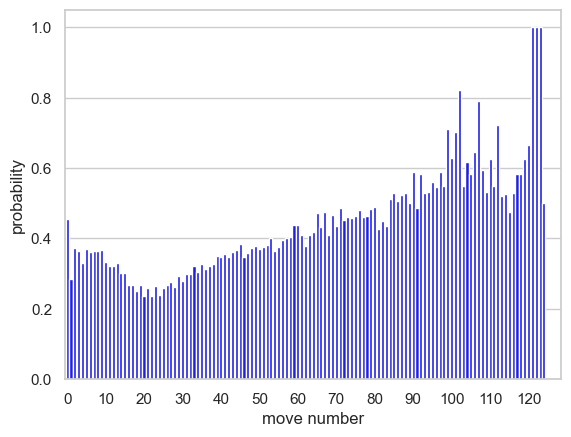

In [211]:
# plot probability of correct move if valid move

rangeOfPlot = [x for x in range(len(probabilityCorrectIfValid.averages()))]
# sns.histplot(x =probabilityValid.averages(), bins=15)
sns.set_theme(style="whitegrid", )
sns.color_palette("light:#5A9", as_cmap=True)
plt.xlabel('move number')
plt.ylabel('probability')
plot = sns.barplot(x=rangeOfPlot, y=probabilityCorrectIfValid.averages(), color="blue")

plt.xticks(rangeOfPlot[::10], rangeOfPlot[::10])
plot

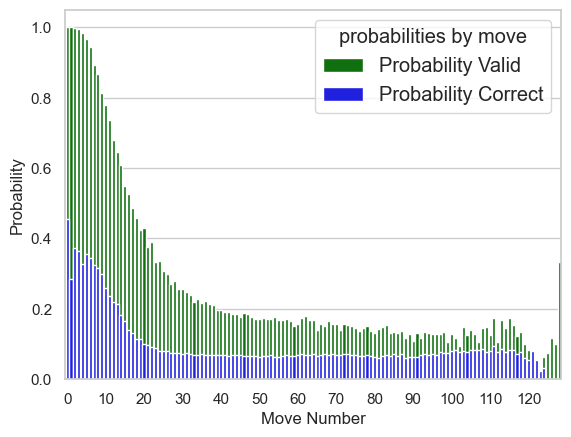

In [212]:
# plot comparing probability of correct move and probability of valid move

rangeOfPlot = [x for x in range(len(probabilityCorrectIfValid.averages()))]
sns.set_theme(style="whitegrid")

# creating subplots
fig, ax = plt.subplots()

# plotting columns
sns.barplot(x=rangeOfPlot, y=probabilityValid.averages(), color="green", ax=ax, label='Probability Valid')
sns.barplot(x=rangeOfPlot, y=probabilityCorrect.averages(), color="blue", ax=ax, label='Probability Correct',alpha=1)

# renaming the axes
ax.set(xlabel="Move Number", ylabel="Probability")

# setting ticks for x-axis
ax.set_xticks(rangeOfPlot[::10])
ax.set_xticklabels(rangeOfPlot[::10])

# adding legend
ax.legend(title='probabilities by move', title_fontsize='large', fontsize='large')

# visualizing illustration
plt.show()

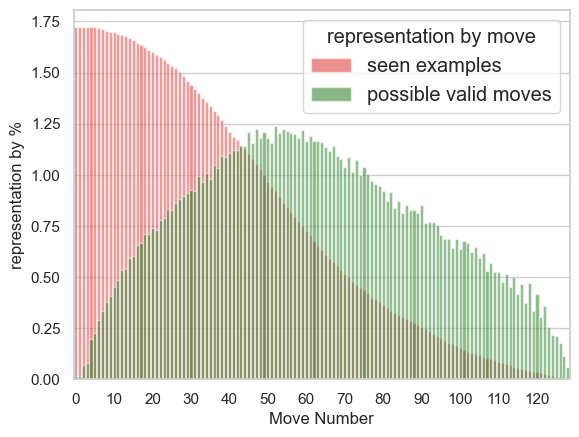

In [170]:
# plot probability of valid move and probability of correct move if valid move
moveCounts = [x.count for x in probabilityValid]
total = sum(moveCounts)
movePercentages = [(x/total) *100 for x in moveCounts]

rangeOfPlot = [x for x in range(len(probabilityCorrectIfValid.averages()))]

sns.set_theme(style="whitegrid", )
sns.color_palette("light:#5A9", as_cmap=True)

validAverage2  =[x for x in probabilityCorrectIfValid.averages()]
# creating subplots
fig, ax = plt.subplots()




sns.barplot(x=rangeOfPlot, y=movePercentages, color="red", label='seen examples',alpha=.5)
# sns.barplot(x=rangeOfPlot, y=validAverage2, color="blue", label='valid move',alpha=.5)
sns.barplot(x=rangeOfPlot, y=[x *100 for x in validCounter.validAverage()], color="green", label='possible valid moves',alpha=.5)
# renaming the axes
ax.set(xlabel="Move Number", ylabel="representation by %")
ax.legend(title='representation by move', title_fontsize='large', fontsize='large')

plt.xticks(rangeOfPlot[::10])

plt.show()